# Modélisation de la Fréquence de Sinistres à partir des Données Contrats Auto

## a. Introduction aux données

Le jeu de données utilisé dans ce projet provient d’un portefeuille d’assurance automobile. Chaque ligne correspond à un contrat (IDpol) observé sur une période donnée, avec son niveau d’exposition (Exposure) et le nombre de sinistres déclarés (ClaimNb).
Les variables descriptives permettent de caractériser le risque associé à chaque assuré et comprennent :

Variables contractuelles :

    - IDpol : identifiant du contrat
    - Exposure : proportion d’année d’exposition (entre 0 et 1)
    - ClaimNb : nombre de sinistres déclarés
    - Variables véhicule
    - VehPower : puissance du véhicule
    - VehAge : âge du véhicule
    - VehBrand : marque du véhicule
    - VehGas : type de carburant
    - Variables conducteur
    - DrivAge : âge du conducteur
    - BonusMalus : coefficient de bonus-malus
    - Variables géographiques
    - Area : zone géographique
    - Density : densité de population de la zone
    - Region : région d’appartenance

## b. Objectif du projet

L’objectif est de modéliser la fréquence de sinistres et de comparer plusieurs approches afin d’identifier le modèle le plus performant pour le pricing.
Les méthodes évaluées sont :

    - GLM (Poisson/Tweedie)
    - GAMs
    - XGBoost
    - LightGBM

La comparaison se fera sur la qualité prédictive, la stabilité et la capacité à capturer les effets importants du risque.

## I.1. Importation des données

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data.csv')
data = data[['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']]
data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3,0,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5,0,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10,0,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11,0,0.84,B,7,0,46,50,B12,Diesel,76,R72


## I.2. Vérification des valeurs manquantes

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  int64  
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 62.1+ MB


## I.3. Vérification des valeurs aberrantes

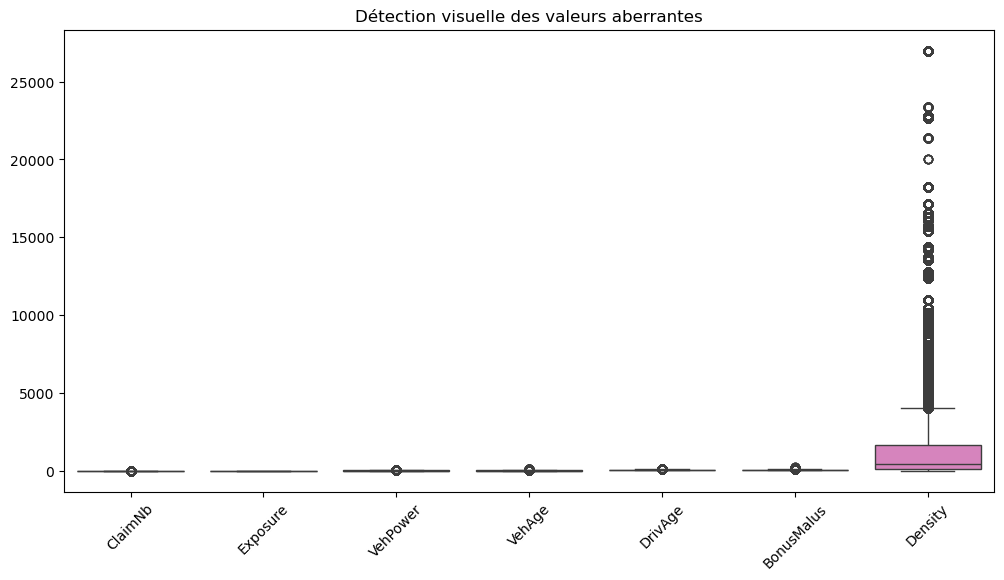

In [5]:
df_numeric = data.drop(columns='IDpol').select_dtypes(include=['float64','int64'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_numeric)
plt.xticks(rotation=45)
plt.title("Détection visuelle des valeurs aberrantes")
plt.show()


## I.4. Analyse descriptive

In [6]:
data.drop(columns='IDpol').describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.038946,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.205036,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,4.000000,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [13]:
data.drop(columns='IDpol').groupby(['Area','VehGas'])['ClaimNb'].describe()


count      mean       std  min  25%  50%  75%  max
Area VehGas                                                       
A    Diesel   60403.0  0.033889  0.188298  0.0  0.0  0.0  0.0  4.0
     Regular  43554.0  0.030238  0.177693  0.0  0.0  0.0  0.0  3.0
B    Diesel   42468.0  0.036263  0.194356  0.0  0.0  0.0  0.0  2.0
     Regular  32991.0  0.033130  0.187256  0.0  0.0  0.0  0.0  3.0
C    Diesel   97202.0  0.039186  0.205823  0.0  0.0  0.0  0.0  3.0
     Regular  94678.0  0.034686  0.191336  0.0  0.0  0.0  0.0  3.0
D    Diesel   70127.0  0.044591  0.219073  0.0  0.0  0.0  0.0  3.0
     Regular  81469.0  0.040433  0.210994  0.0  0.0  0.0  0.0  4.0
E    Diesel   56646.0  0.047611  0.229696  0.0  0.0  0.0  0.0  4.0
     Regular  80521.0  0.042523  0.216564  0.0  0.0  0.0  0.0  4.0
F    Diesel    5290.0  0.043289  0.220472  0.0  0.0  0.0  0.0  3.0
     Regular  12664.0  0.043035  0.219759  0.0  0.0  0.0  0.0  3.0

C:\Users\HP\AppData\Local\Temp\ipykernel_21684\602761834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')


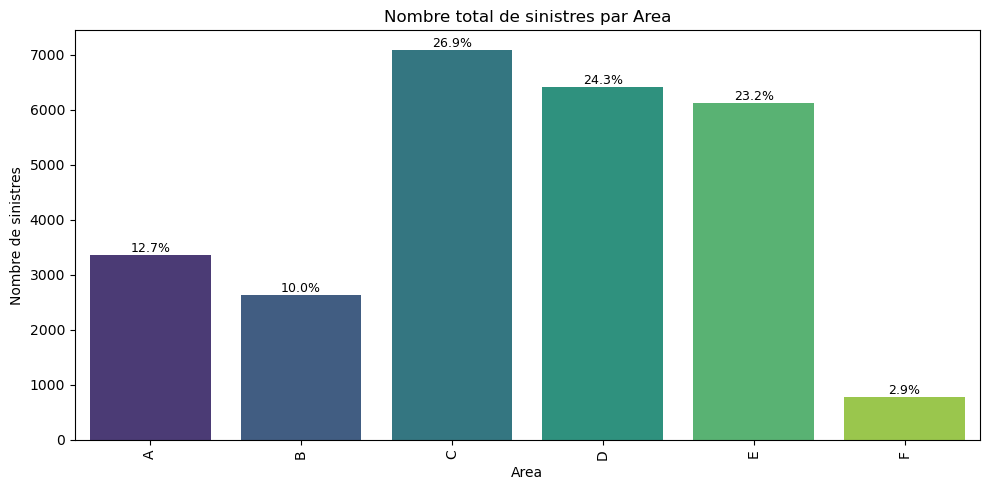

C:\Users\HP\AppData\Local\Temp\ipykernel_21684\602761834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')


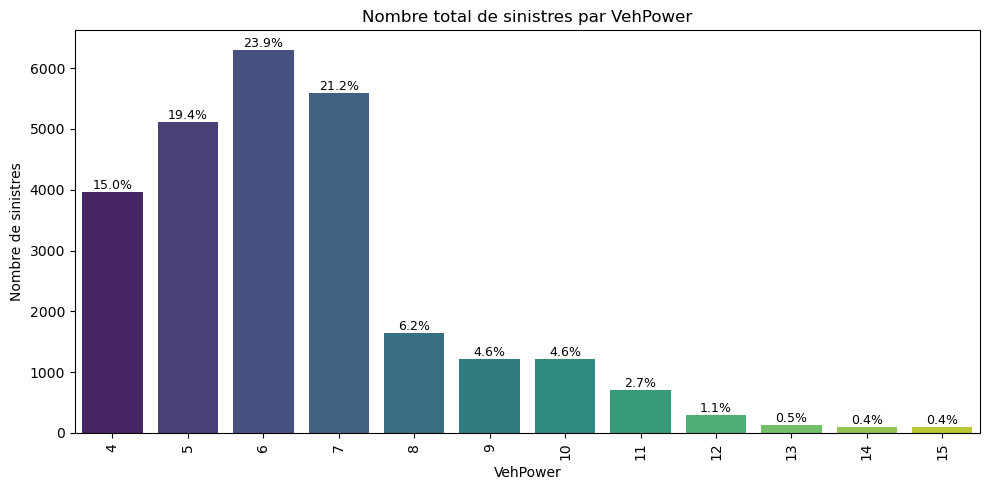

C:\Users\HP\AppData\Local\Temp\ipykernel_21684\602761834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')


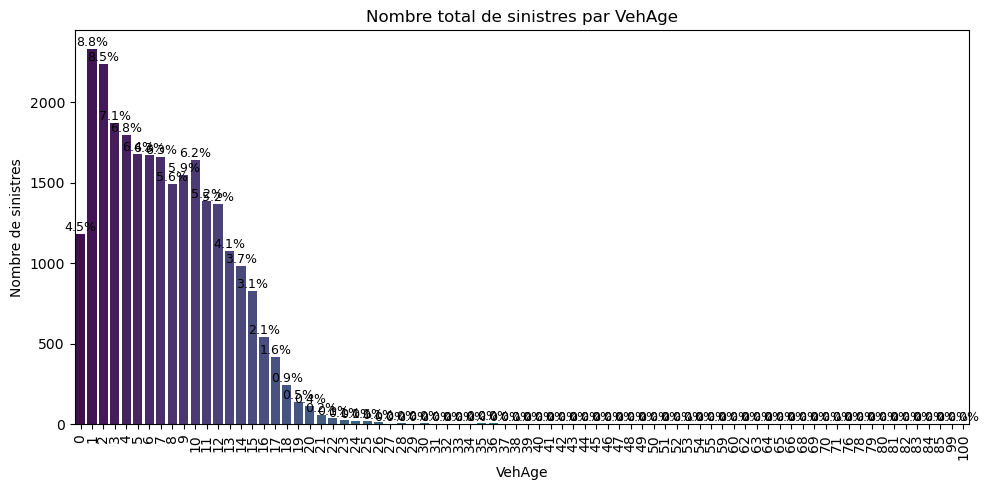

C:\Users\HP\AppData\Local\Temp\ipykernel_21684\602761834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')


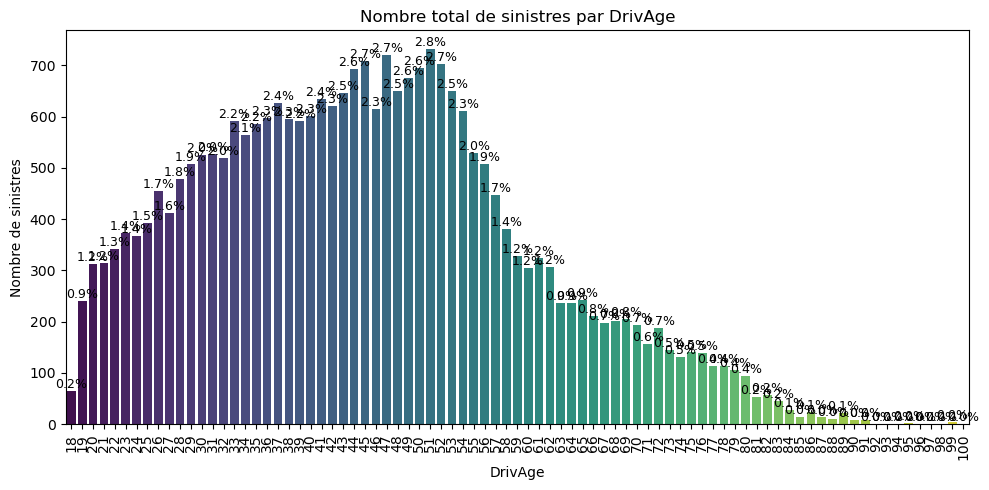

C:\Users\HP\AppData\Local\Temp\ipykernel_21684\602761834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')


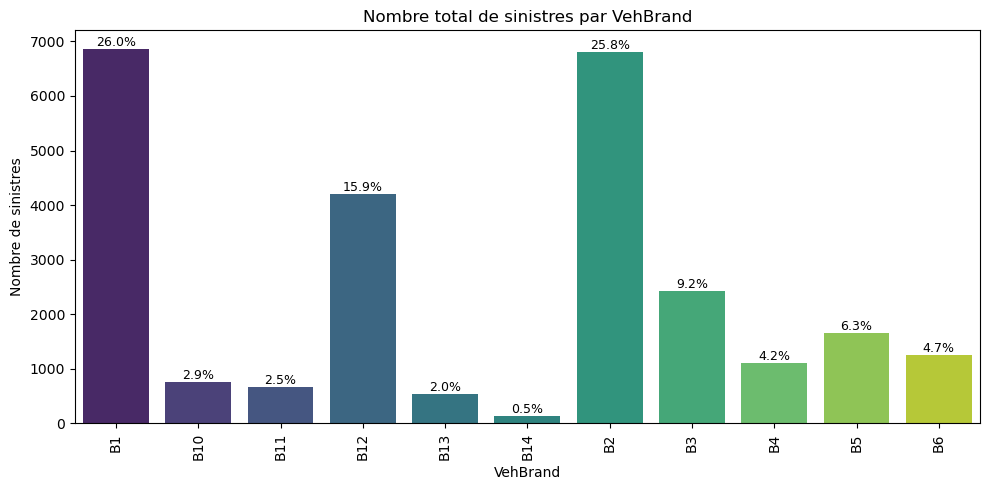

C:\Users\HP\AppData\Local\Temp\ipykernel_21684\602761834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')


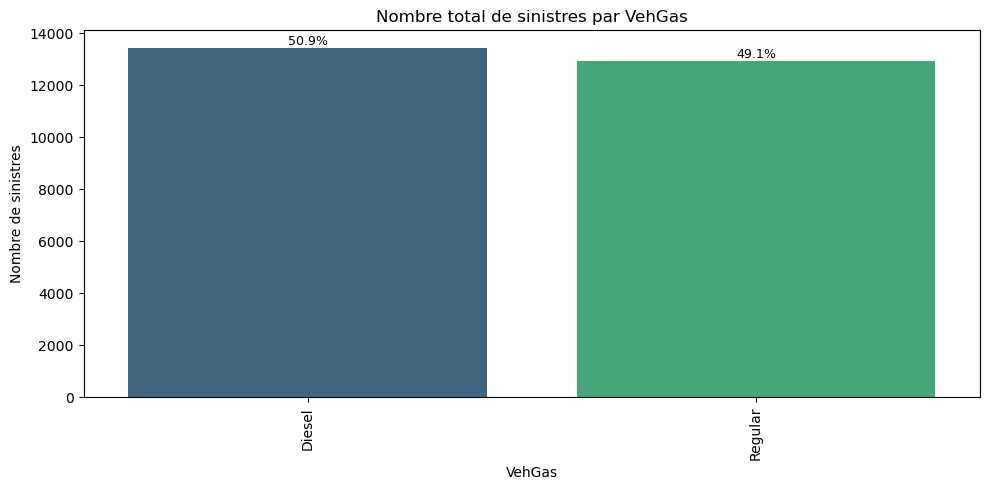

C:\Users\HP\AppData\Local\Temp\ipykernel_21684\602761834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')


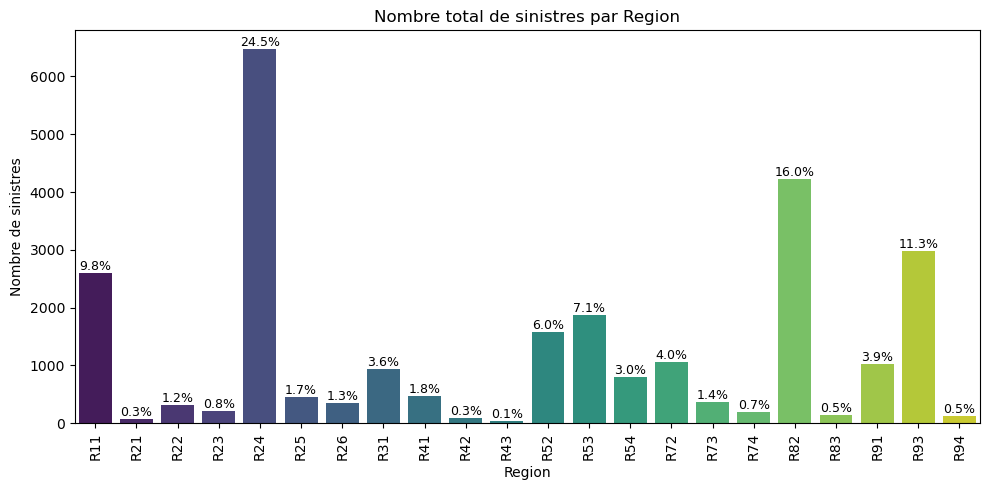

In [36]:
variables = [ 'Area', 'VehPower', 'VehAge', 'DrivAge', 'VehBrand', 'VehGas',  'Region']

total_claims = data['ClaimNb'].sum()

for var in variables:
    plt.figure(figsize=(10,5))
    
    grouped = data.groupby(var)['ClaimNb'].sum().reset_index()
    
    
    
    grouped['Perc'] = grouped['ClaimNb'] / total_claims * 100
    
    ax = sns.barplot(data=grouped, x=var, y='ClaimNb', palette='viridis')
    plt.title(f"Nombre total de sinistres par {var}")
    plt.xlabel(var)
    plt.ylabel("Nombre de sinistres")
    plt.xticks(rotation=90)
    
    # ➤ Correction : utiliser les positions exactes des barres
    for index, bar in enumerate(ax.patches):
        height = bar.get_height()
        perc = grouped.iloc[index]['Perc']
        ax.text(bar.get_x() + bar.get_width()/2,
                height,
                f"{perc:.1f}%",
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()


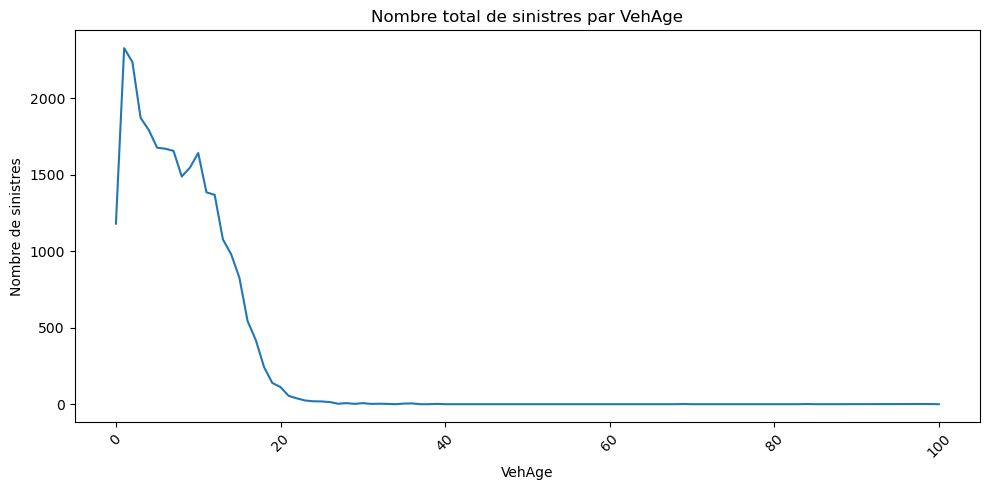

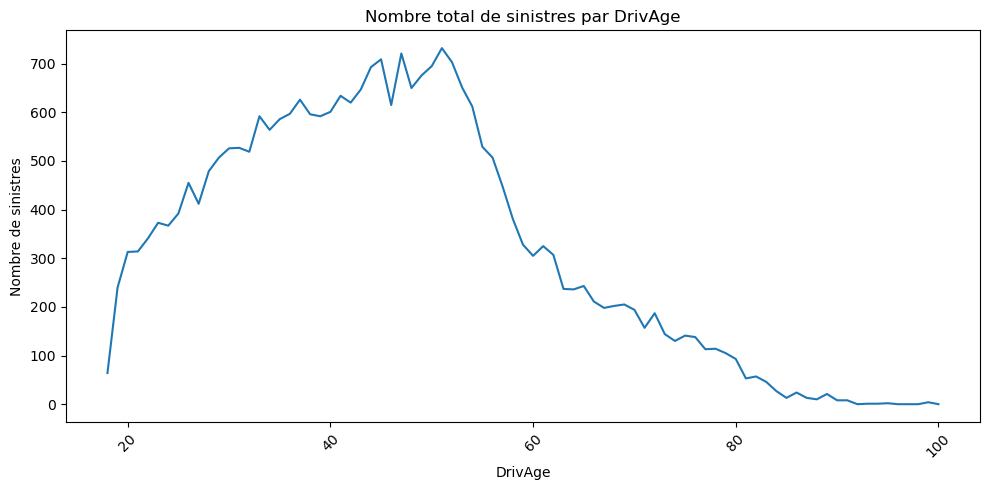

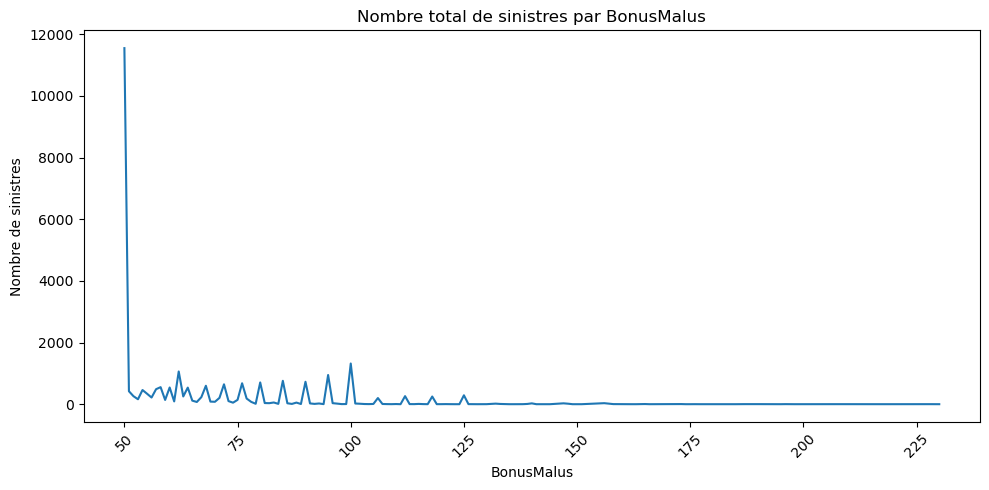

In [37]:
variables = [ 'VehAge', 'DrivAge', 'BonusMalus']

total_claims = data['ClaimNb'].sum()

for var in variables:
    plt.figure(figsize=(10,5))
    
    grouped = data.groupby(var)['ClaimNb'].sum().reset_index()
    
    
    
    grouped['Perc'] = grouped['ClaimNb'] / total_claims * 100
    
    ax = sns.lineplot(data=grouped, x=var, y='ClaimNb')
    plt.title(f"Nombre total de sinistres par {var}")
    plt.xlabel(var)
    plt.ylabel("Nombre de sinistres")
    plt.xticks(rotation=45)
    
    # ➤ Correction : utiliser les positions exactes des barres
    for index, bar in enumerate(ax.patches):
        height = bar.get_height()
        perc = grouped.iloc[index]['Perc']
        ax.text(bar.get_x() + bar.get_width()/2,
                height,
                f"{perc:.1f}%",
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

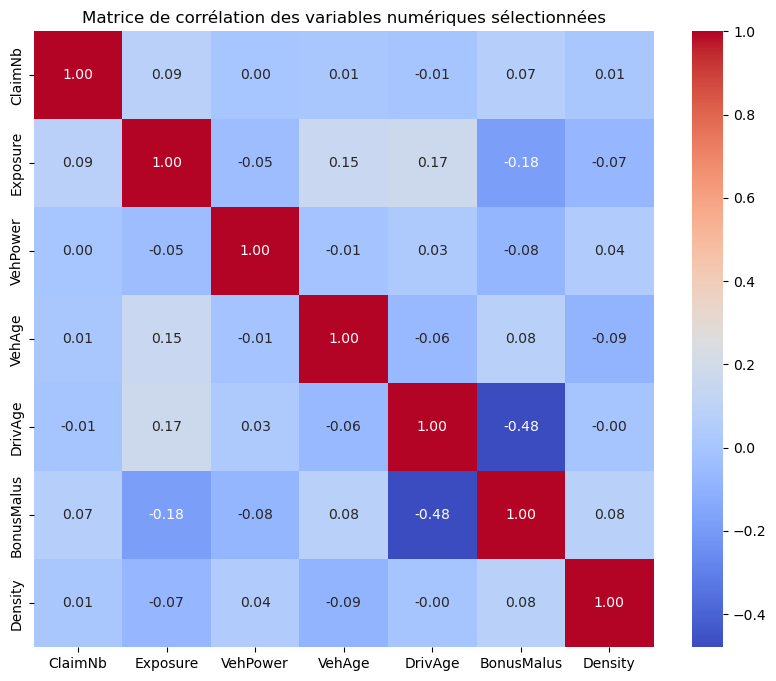

In [38]:
data.columns
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection manuelle des colonnes d'intérêt
cols = ['ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']

# On garde uniquement les colonnes présentes et numériques
num_col = data[cols].select_dtypes(include='number').columns

# Calcul de la matrice de corrélation
correl = data[num_col].corr()

# Affichage du heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correl, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation des variables numériques sélectionnées")
plt.show()


c:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **p

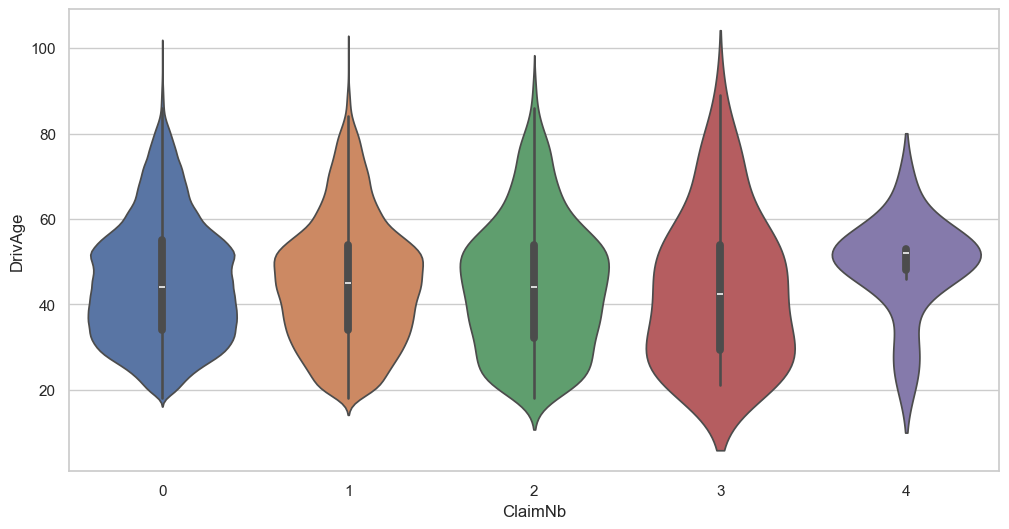

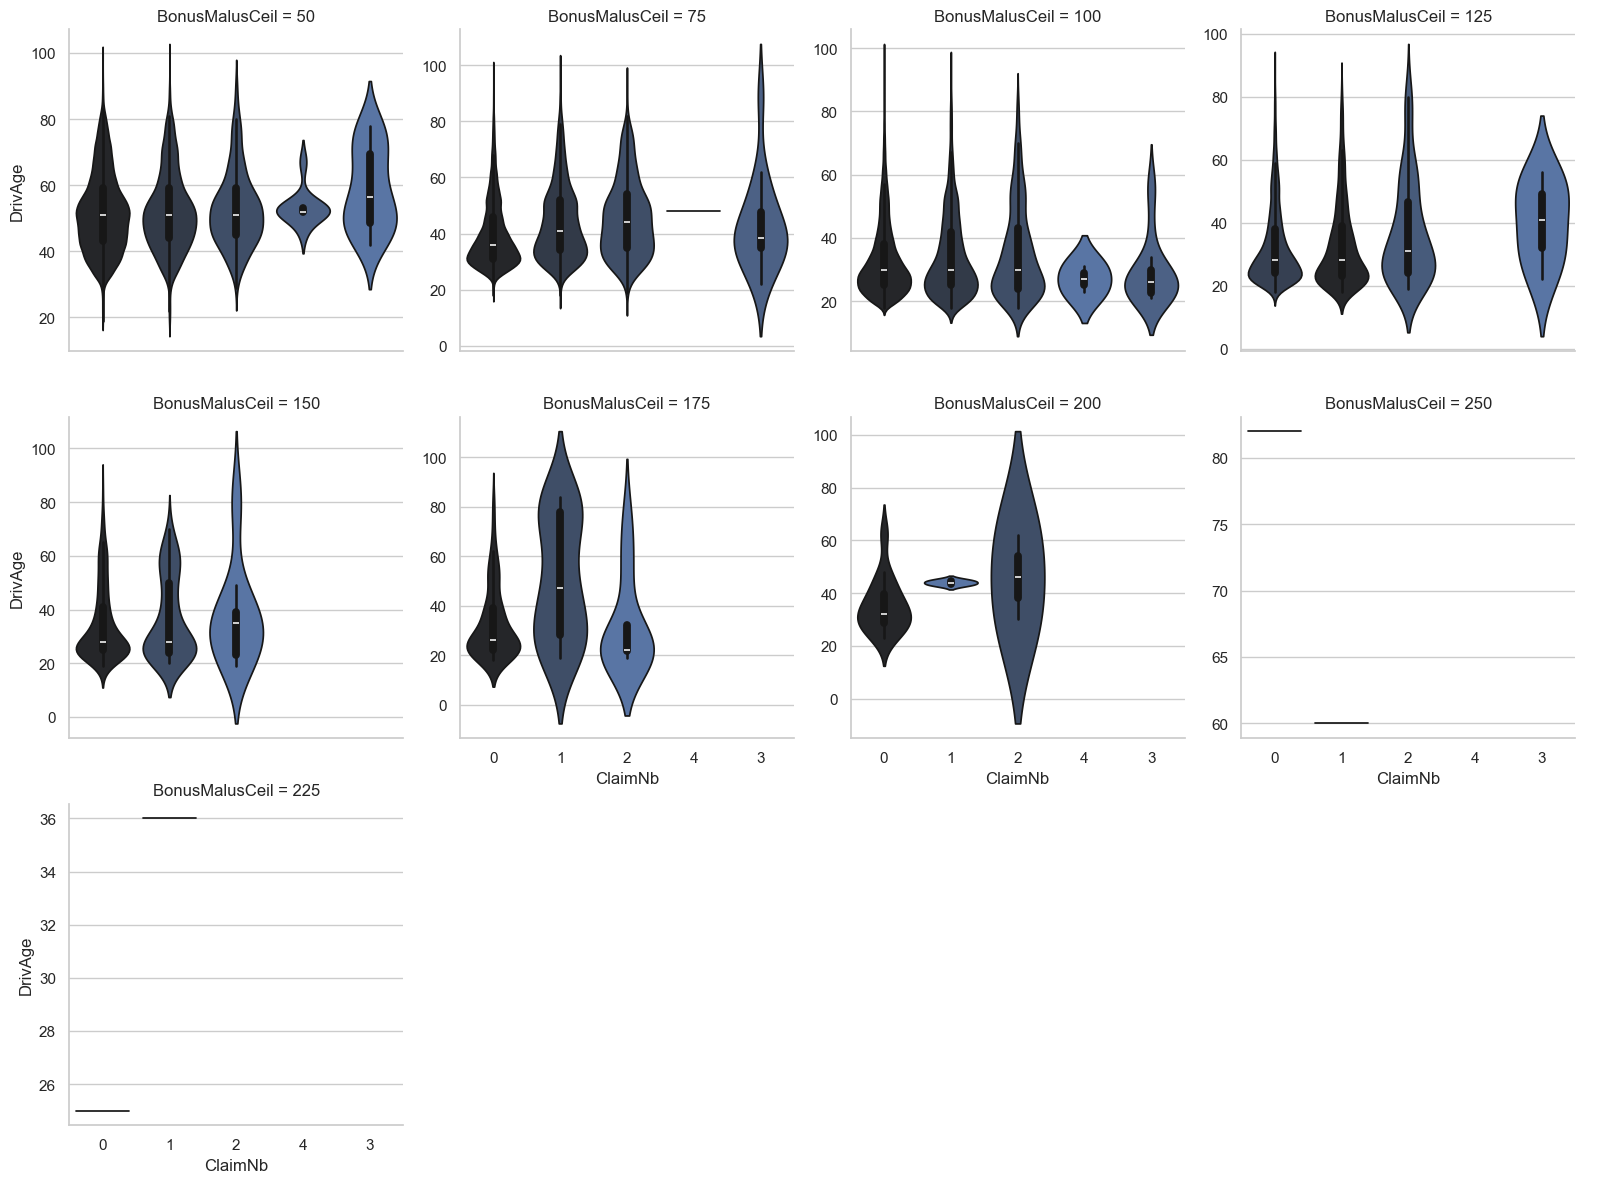

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Filtrer les données
df = data.copy()

# 2. Créer les nouvelles colonnes
df["BonusMalusCeil"] = np.ceil(df["BonusMalus"] / 25) * 25
df["BonusMalusCeil"] = df["BonusMalusCeil"].astype(int).astype(str)

df["ClaimNb"] = df["ClaimNb"].astype(str)

# 3. Plot violin (équivalent ggplot)
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.violinplot(
    data=df,
    x="ClaimNb",
    y="DrivAge",
    hue="ClaimNb",
    dodge=False
)

# 4. Facet (un graphique par groupe BonusMalusCeil)
g = sns.FacetGrid(df, col="BonusMalusCeil", col_wrap=4, height=4, sharey=False)
g.map_dataframe(
    sns.violinplot,
    x="ClaimNb",
    y="DrivAge",
    hue="ClaimNb",
    dodge=False
)

g.add_legend()
plt.show()


In [ ]:
# copy data
dat1 = data.copy()

# 1. AreaGLM : convertir Area en entier
dat1["AreaGLM"] = dat1["Area"].astype("category").cat.codes

# 2. VehPowerGLM : caper la puissance à 9 puis convertir en facteur
dat1["VehPowerGLM"] = np.minimum(dat1["VehPower"], 9).astype("category")

# 3. VehAgeGLM : groupes (0→1), (1-10→2), (>=11→3)
dat1["VehAgeGLM"] = pd.cut(
    dat1["VehAge"],
    bins=[-1, 0, 10, 200],
    labels=["1", "2", "3"]
).astype("category")

# set reference level = "2" (comme relevel en R)
dat1["VehAgeGLM"] = dat1["VehAgeGLM"].cat.reorder_categories(["2", "1", "3"], ordered=True)

# 4. DrivAgeGLM : tranches d’âge
bins = [17, 20, 25, 30, 40, 50, 70, 150]
labels = ["1", "2", "3", "4", "5", "6", "7"]
dat1["DrivAgeGLM"] = pd.cut(
    dat1["DrivAge"],
    bins=bins,
    labels=labels,
    include_lowest=True
).astype("category")

# référence = groupe "5"
dat1["DrivAgeGLM"] = dat1["DrivAgeGLM"].cat.reorder_categories(["5", "1", "2", "3", "4", "6", "7"], ordered=True)

# 5. BonusMalusGLM : cap à 150
dat1["BonusMalusGLM"] = np.minimum(dat1["BonusMalus"], 150)

# 6. DensityGLM : transformation logarithmique
dat1["DensityGLM"] = np.log(dat1["Density"])

# 7. Region : définir la référence = "R24"
dat1["Region"] = dat1["Region"].astype("category")
if "R24" in dat1["Region"].unique():
    dat1["Region"] = dat1["Region"].cat.reorder_categories(
        ["R24"] + [c for c in dat1["Region"].unique() if c != "R24"],
        ordered=True
    )

# Affichage
print(dat1.head())


   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0      1        0      0.10    D         5       0       55          50   
1      3        0      0.77    D         5       0       55          50   
2      5        0      0.75    B         6       2       52          50   
3     10        0      0.09    B         7       0       46          50   
4     11        0      0.84    B         7       0       46          50   

  VehBrand   VehGas  Density Region  AreaGLM VehPowerGLM VehAgeGLM DrivAgeGLM  \
0      B12  Regular     1217    R82        3           5         1          6   
1      B12  Regular     1217    R82        3           5         1          6   
2      B12   Diesel       54    R22        1           6         2          6   
3      B12   Diesel       76    R72        1           7         1          5   
4      B12   Diesel       76    R72        1           7         1          5   

   BonusMalusGLM  DensityGLM  
0             50    7.104144  


## 1. Poisson Deviance pondérée (PDW)

In [ ]:
def PDW(pred, obs, exposure=None):
    """
    Weighted Poisson Deviance:
    pred  = predicted claim frequency (λ̂)
    obs   = observed claim numbers
    exposure = exposure weights
    """
    pred = np.asarray(pred)
    obs = np.asarray(obs)

    if exposure is None:
        exposure = np.ones_like(obs)
    else:
        exposure = np.asarray(exposure)

    # Avoid division by zero
    pred = np.clip(pred, 1e-10, None)

    dev = exposure * (pred - obs + obs * np.log(obs / pred))
    return 200 * dev.sum() / exposure.sum()


## 2. PDW2 — Affichage Learn/Test

In [31]:
def PDW2(txt, pred_learn, obs_learn, exp_learn,
                pred_test,  obs_test,  exp_test):
    
    learn_pd = PDW(pred_learn, obs_learn, exp_learn)
    test_pd  = PDW(pred_test,  obs_test,  exp_test)

    return f"{txt}, Learn/Test: {learn_pd:.2f}% / {test_pd:.2f}%"


## 3. CF2 — Claim Frequency Learn/Test

In [32]:
def CF2(txt, obs_learn, exp_learn, obs_test, exp_test):
    freq_learn = obs_learn.sum() / exp_learn.sum() * 100
    freq_test  = obs_test.sum()  / exp_test.sum()  * 100
    
    return f"{txt}: {freq_learn:.2f}% / {freq_test:.2f}%"


## 4. Benchmark.GLM2 — Indice d’amélioration vs GLM2

In [33]:
def Benchmark_GLM2(txt, pred, 
                   test_ClaimNb, test_Exposure, 
                   test_fit_cf, test_fitGLM2):
    """
    Compare model performance vs GLM2 reference.
    """
    pd_pred = PDW(pred, test_ClaimNb, test_Exposure)
    pd_const = PDW(test_fit_cf, test_ClaimNb, test_Exposure)
    pd_glm2 = PDW(test_fitGLM2, test_ClaimNb, test_Exposure)
    
    index = ((pd_pred - pd_const) / (pd_glm2 - pd_const)) * 100

    return f"GLM2-Improvement-Index (PD test) of {txt}: {index:.1f}%"


In [ ]:
# --- 1. Créer 5 folds (20% chacun) ---
k = 5
np.random.seed(42)  # même logique que set.seed(42)

# sample(1:k, nrow(dat1), replace=TRUE)
dat1["fold"] = np.random.choice(range(1, k+1), size=len(dat1), replace=True)

# --- 2. Split Learn/Test ---
learn = dat1[dat1["fold"] != 5]   # 80%
test  = dat1[dat1["fold"] == 5]   # 20%

# --- 3. Fonction CF2 (définition si nécessaire) ---
def CF2(txt, obs_learn, exp_learn, obs_test, exp_test):
    freq_learn = obs_learn.sum() / exp_learn.sum() * 100
    freq_test  = obs_test.sum()  / exp_test.sum()  * 100
    
    return f"{txt}: {freq_learn:.2f}% / {freq_test:.2f}%"

# --- 4. Affichage de la fréquence sinistre ---
print(CF2("Claim Frequency (Actual) Learn/Test",
          learn["ClaimNb"], learn["Exposure"],
          test["ClaimNb"],  test["Exposure"]))


Claim Frequency (Actual) Learn/Test: 7.40% / 7.25%
